In [1]:
import numpy as np
import pandas as pd
from numpy.typing import NDArray
import matplotlib.pyplot as plt

# The market, and random movements explained

For next session!

# Parameter Estimation

We reviewed in our last session that the market can be modelled using a GBM, of the form:
$$ds = \mu S_t dt + \sigma S_t dX(t)$$
where $\quad dW_t$ is a draw from $N(0,1)$. We have found an analytical solution last session, but we aim to find numerical solutions and compare them to the analytical solution we found for our parameters. 

However, we did not discuss the methods from which we can obtain these parameters from real world data, and we will review two different methods for obtaining this. Hence, we wish to find the parameters $\mu$ and $\sigma$ that best describes the distribution. 

In [48]:
from pandas import Timestamp


ARRAY_F = NDArray[np.float64]
DEFAULT_DT = 1.0 /252

def create_weiner_array(size: int | tuple[int,...]) -> ARRAY_F:
    dX = np.random.normal(0, np.sqrt(DEFAULT_DT), size)
    X = dX.cumsum() 
    return X

def create_gbm(mu: float, sigma: float,  dt: float, s_0: float, W: ARRAY_F) -> ARRAY_F:
    S  = np.zeros_like(W)
    S[0] = s_0
    for i in range(1, len(W)):
        S[i] = mu * S[i-1] * dt + sigma * S[i-1] * W[i] 

    return S

We invite you to play around wiith these functions, and concretely produce 2 plots:
1. Families of paths with different parameter values for gbm
2. Average paths and path distributions at different points in time. 

What is evident from these distributions?

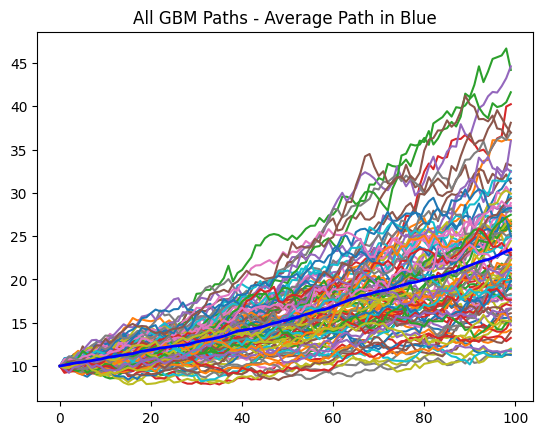

Text(0.5, 1.0, 'PDF of GBM at Last Time Step')

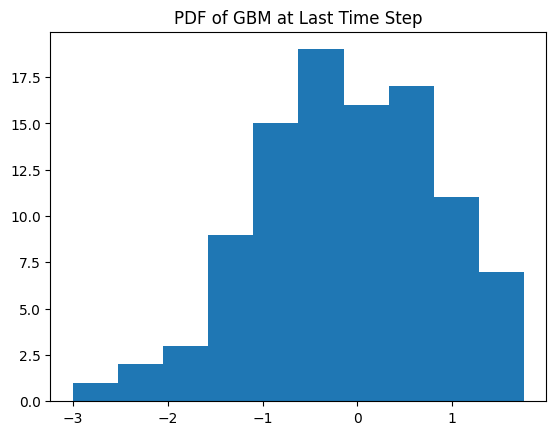

In [170]:
W = np.random.normal(size=(100, 99))


realised_paths = []

# plotting all paths
for path in W.T:
    a = create_gbm(100.9, 0.03, 0.01, 10, path)
    realised_paths.append(a)
    plt.plot(a)

# compute average path
average_path = np.mean(realised_paths, axis=0)


# plot average path thicker and darker
plt.plot(average_path, linewidth=2, color='b')
plt.title('All GBM Paths - Average Path in Blue')
plt.show()

# pdf of end of process
plt.hist(W[:, -1])
plt.title("PDF of GBM at Last Time Step")

# Maximum Likelihood Estimation (MLE)

We wish to find the parameters $\mu$ and $\sigma$ that maximise the total probability that the observed data was drawn from the distribution generated with parameters $\mu$ and $\sigma$. Recall that GBM has an analytical solution:
$$S_t = S_0 \text{exp}\left((\mu - \frac{1}{2}\sigma^2)t + \sigma W_t\right)$$
Let $X = \ln{S}$, hence we find that:

$$ dX_t = X_{t+dt}-X_t = \ln  {S_{t+dt} - \ln S_t} = \ln\left(\frac{S_{t+dt}}{S_t}\right)$$
which simplifies to:

$$dX_t = (\mu - \frac{1}{2}\sigma^2)dt + \sigma dW_t$$
we can conclude that:
$$dX ∼ \mathcal{N}  ((\mu - \frac{1}{2}\sigma^2) \Delta t_i , \sigma^2 \Delta t_i)$$
From the normal distribution function, letting $m = \mu - \frac{1}{2}\sigma^2$, we obtain that the probability density of $(Y_i)_{i=0}^n$ is:

$$
L(\mu,\sigma)
=\prod_{i=1}^n
\frac{1}{\sqrt{2\pi\,\sigma^2\Delta t_i}}
\exp\!\left(
-\frac{\big(Y_i-m\Delta t_i\big)^2}{2\,\sigma^2\Delta t_i}
\right)
$$
and hence the log-likelihood is described by:
$$
\ell(\mu,\sigma):=\ln L(\mu,\sigma)
= -\tfrac12\sum_{i=1}^n
\left[
\ln\!\big(2\pi\,\sigma^2\Delta t_i\big)
+\frac{\big(Y_i-m\Delta t_i\big)^2}{\sigma^2\Delta t_i}
\right].
$$
Thus, we aim to maximise the log likelihood of the parameters. We can find the analytical solution by setting partial derivatives equal to zero, below are the equations for the solutions:
$$
\sigma^2 = \frac{1}{n}\sum_{i=1}^n \frac{(Y_i - \hat{m}\Delta t_i)^2}{\Delta t_i}
\\
\mu = \hat{m} + \frac{1}{2}\sigma^2 \\
\text{where:} \\ \\ \\
\hat{m} = \frac{\sum_{i=1}^n Y_i}{\sum_{i=0}^n \Delta t_i}


## Function optimiser:
$$
\ell(\mu,\sigma)
= -\tfrac12\sum_{i=1}^n
\left[
\ln(\sigma^2)
+\frac{\big(Y_i-m\Delta t_i\big)^2}{\sigma^2\Delta t_i}
\right]
+ O(1)
$$

In [215]:
def log_likelihood(mu: float, sigma: float, equity_path: ARRAY_F):
        m = mu - (1/2) * sigma * sigma
        ll_sum = 0
        for i in range(len(equity_path)):
            ll_sum += np.log(sigma*sigma) + ((equity_path[i] - m*DEFAULT_DT)**2 / (sigma*sigma*DEFAULT_DT))

        ll_sum_adjusted = (-1/2) * ll_sum
        return ll_sum_adjusted
            

def optimise_params_mle_analytical(equity_path: ARRAY_F) -> tuple[float, float]:
    prices = np.asarray(equity_path, dtype=np.float64)
    if prices.ndim != 1:
        raise ValueError("equity_path must be a 1D array of prices")
    if prices.size < 2:
        raise ValueError("equity_path must contain at least two prices")
    if not np.all(prices > 0.0):
        raise ValueError("all prices must be strictly positive")
    
    log_prices = np.log(prices)
    log_returns = np.diff(log_prices)

    n_observations = log_returns.size

    mean_log_return = float(np.mean(log_returns))
    centered_log_returns = log_returns - mean_log_return

    # \hat{\sigma}^2 = (1/(n \Delta t)) \sum (Y_i - \bar Y)^2
    sigma_squared_hat = float((centered_log_returns @ centered_log_returns) / (n_observations * DEFAULT_DT))
    if sigma_squared_hat <= 0.0:
        raise ValueError("estimated variance is non-positive; check input data")

    sigma_hat = float(np.sqrt(sigma_squared_hat))

    # \hat{\mu} = \bar Y / \Delta t + (1/2) \hat{\sigma}^2
    mu_hat = float(mean_log_return / DEFAULT_DT + 0.5 * sigma_squared_hat)

    return mu_hat, sigma_hat

def optimise_params_mle_numerical(
    equity_path: ARRAY_F,
    mu_bounds: tuple[float, float] = (-2.0, 2.0),
    sigma_bounds: tuple[float, float] = (1e-6, 2.0),
    mu_grid_size: int = 301,
    sigma_grid_size: int = 301,
) -> tuple[float, float]:
    prices = np.asarray(equity_path, dtype=np.float64)
    if prices.ndim != 1:
        raise ValueError("equity_path must be a 1D array of prices")
    if prices.size < 2:
        raise ValueError("equity_path must contain at least two prices")
    if not np.all(prices > 0.0):
        raise ValueError("all prices must be strictly positive")

    mu_grid = np.linspace(mu_bounds[0], mu_bounds[1], mu_grid_size, dtype=np.float64)
    sigma_grid = np.linspace(sigma_bounds[0], sigma_bounds[1], sigma_grid_size, dtype=np.float64)

    best_mu = 0.0
    best_sigma = 0.0
    best_ll = -np.inf

    for sigma_candidate in sigma_grid:
        for mu_candidate in mu_grid:
            ll_value = log_likelihood(mu_candidate, sigma_candidate, prices)
            if ll_value > best_ll:
                best_ll = ll_value
                best_mu = mu_candidate
                best_sigma = sigma_candidate

    return float(best_mu), float(best_sigma)

# Project

Implement the functions below, and for an added difficulty; derive and recreate the functions above. We will expand on this later!

In [288]:
import yfinance as yf

def model_equity(ticker: str, start_date: Timestamp, end_date: Timestamp) -> ARRAY_F:
    price_path = yf.download(ticker, start=start_date, end=end_date)['Close'].to_numpy().T[0]

    mu_hat, sigma_hat = optimise_params_mle_analytical(price_path)

    # mu_numerical, sigma_numerical = optimise_params_mle_numerical(price_path)

    # print(f'Mu error: {np.sqrt(np.power(mu_hat-mu_numerical, 2))}')
    # print(f'Sigma error: {np.sqrt(np.power(sigma_hat-sigma_numerical, 2))}')

    return (mu_hat, sigma_hat, price_path[0], len(price_path))



def simulate_equity_matrix(tickers: list[str]):
    # Create a path given the mean and variance
    start = '2020-10-10'
    end = '2025-10-10'

    price_paths = []

    for ticker in tickers:
        # get mean, std, initial price, and number of values from model_equity
        mu, sigma, S0, n = model_equity(ticker=ticker, start_date=start, end_date=end)
        mu = mu
        sigma = sigma
        
        # create empty array to store prices
        St = np.zeros(n)

        St[0] = S0

        # create random path
        W = np.random.normal(size=(n))

        # ask for explanation of how we have this discritisation. Not like the formula above
        # iterate through time steps, updating path
        for t in range(n-1):
            t_term = (mu - (0.5 * sigma*sigma)) * DEFAULT_DT
            St[t+1] = St[t] * np.exp(t_term + sigma*W[t]*np.sqrt(DEFAULT_DT))

        price_paths.append(St)
        
    return price_paths

def retrieve_equity_matrix(tickers: list[str]):
    ...

C:\Users\adamf\AppData\Local\Temp\ipykernel_21980\254236255.py:4: FutureWarning: YF.download() has changed argument auto_adjust default to True
  price_path = yf.download(ticker, start=start_date, end=end_date)['Close'].to_numpy().T[0]
[*********************100%***********************]  1 of 1 completed


C:\Users\adamf\AppData\Local\Temp\ipykernel_21980\254236255.py:4: FutureWarning: YF.download() has changed argument auto_adjust default to True
  price_path = yf.download(ticker, start=start_date, end=end_date)['Close'].to_numpy().T[0]
[*********************100%***********************]  1 of 1 completed
C:\Users\adamf\AppData\Local\Temp\ipykernel_21980\254236255.py:4: FutureWarning: YF.download() has changed argument auto_adjust default to True
  price_path = yf.download(ticker, start=start_date, end=end_date)['Close'].to_numpy().T[0]
[*********************100%***********************]  1 of 1 completed
C:\Users\adamf\AppData\Local\Temp\ipykernel_21980\3773508559.py:14: FutureWarning: YF.download() has changed argument auto_adjust default to True
  price_path = yf.download(ticker, start=START_DATE, end=END_DATE)['Close'].to_numpy().T[0]
[*********************100%***********************]  1 of 1 completed
C:\Users\adamf\AppData\Local\Temp\ipykernel_21980\3773508559.py:14: FutureWarning:

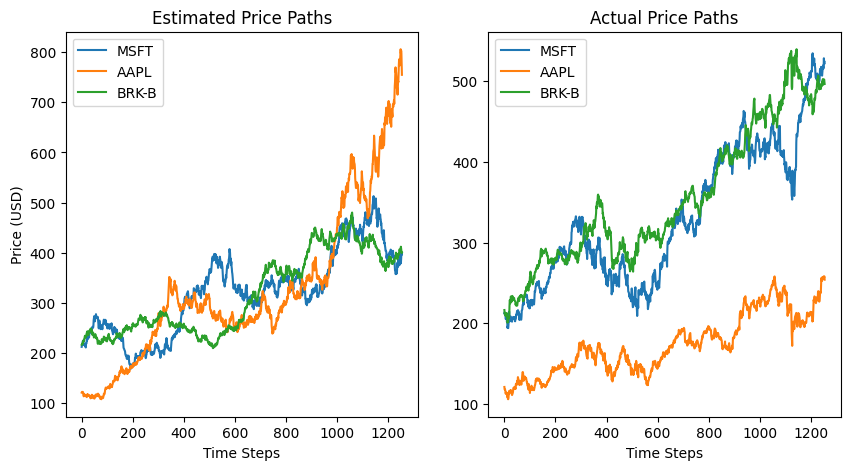

In [289]:
START_DATE = '2020-10-10'
END_DATE = '2025-10-10'
tickers = ['MSFT', 'AAPL', 'BRK-B']

estimated_path = simulate_equity_matrix(tickers)

fig, (ax1, ax2) = plt.subplots(1,2)
fig.set_figheight(5)
fig.set_figwidth(10)

for i, ticker in enumerate(tickers):

    ax1.plot(estimated_path[i], label=ticker)
    price_path = yf.download(ticker, start=START_DATE, end=END_DATE)['Close'].to_numpy().T[0]
    ax2.plot(price_path, label=ticker)

ax1.set_title("Estimated Price Paths")
ax1.legend()
ax1.set_xlabel("Time Steps")
ax1.set_ylabel("Price (USD)")

ax2.set_title("Actual Price Paths")
ax2.legend()
ax2.set_xlabel("Time Steps")
plt.show()


Mu error: 1.7855199528620602
Sigma error: 1.7410925066647747

C:\Users\adamf\AppData\Local\Temp\ipykernel_21980\2435394121.py:7: FutureWarning: YF.download() has changed argument auto_adjust default to True
  price_path = yf.download(ticker, start=START_DATE, end=END_DATE)['Close'].to_numpy().T[0]
[*********************100%***********************]  1 of 1 completed
C:\Users\adamf\AppData\Local\Temp\ipykernel_21980\2435394121.py:7: FutureWarning: YF.download() has changed argument auto_adjust default to True
  price_path = yf.download(ticker, start=START_DATE, end=END_DATE)['Close'].to_numpy().T[0]
[*********************100%***********************]  1 of 1 completed


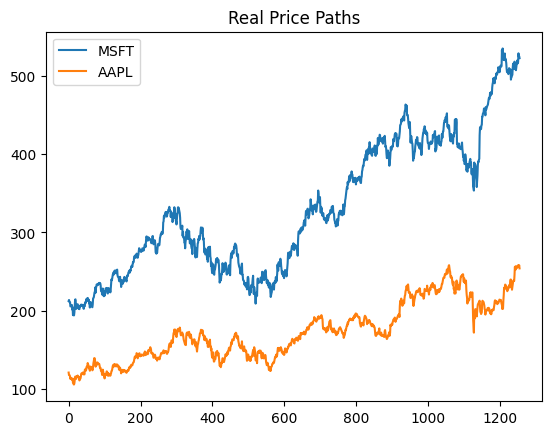

In [271]:
START_DATE = '2020-10-10'
END_DATE = '2025-10-10'
tickers = ['MSFT', 'AAPL']

for i, ticker in enumerate(tickers):

    price_path = yf.download(ticker, start=START_DATE, end=END_DATE)['Close'].to_numpy().T[0]

    plt.plot(price_path, label=ticker)

plt.legend()
plt.title("Real Price Paths")
plt.show()